In [4]:
import numpy as np
import pandas as pd
from utils.categorical_encoders import CategoricalEncoders

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
# 1. Leer el dataset
DATASET_PATH = './data/2_data_preprocesada.parquet'
dataset = pd.read_parquet(DATASET_PATH)
dataset

,FBK_ULT12,FBK_BEST12,COD_SALA,DEPARTAMENTO,SEGMENTO,RANGO_INGRESOS,NUMPRIORIZACION,NC_DISTR12,TOTGEST6,DIAS_ULT6,DIAS_BEST12,NC_CTD12,NC_DIAS6,TARGET,DF_TYPE
0,TLV,TLV,EC,FUERA DE LIMA,2,Entre S/.4000-10000,1,0.333333,6.000000,8.000000,8.000000,2.0,58.0,1,TRAIN
1,TLV,TLV,PP,LIMA,1BC,Entre S/.4000-10000,1,0.461538,13.000000,9.000000,46.000000,6.0,9.0,1,TRAIN
2,TLV,TLV,PA,LIMA,2,Entre S/.1000-4000,1,0.666667,2.000000,127.000000,223.000000,4.0,127.0,1,TRAIN
3,TLV,TLV,NC,LIMA,2,Entre S/.1000-4000,1,0.587062,4.000000,49.000000,49.000000,4.0,38.0,1,TRAIN
4,TLV,TLV,EC,FUERA DE LIMA,3,Entre S/.4000-10000,1,0.187500,10.000000,27.000000,27.000000,3.0,140.0,1,TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305600,SIN DATOS,SIN DATOS,NC,FUERA DE LIMA,5,Entre S/.600-1000,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0,TEST
1305601,SIN DATOS,SIN DATOS,2DA,FUERA DE LIMA,1BC,Entre S/.4000-10000,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0,TEST
1305602,SIN DATOS,SIN DATOS,NC,LIMA,3,Sin ingresos,1,0.587062,7.463895,44.627989,80.041789,4.0,38.0,1,TEST
1305603,SIN DATOS,SIN DATOS,NC,LIMA,3,Entre S/.1000-4000,2,0.587062,7.463895,44.627989,80.041789,4.0,38.0,0,TEST


In [3]:
# 2. Obtener las columnas binarias y categóricas
categorical = CategoricalEncoders(dataset=dataset)
binary_columns, categorical_columns = categorical.get_binary_categorical_columns()

# 3. Obtener los datos codificados
def get_list_data_encoded():
    encoded_methods = ['LabelEncoder', 'OneHotEncoder', 'OrdinalEncoder', 'FrequencyEncoder', 'BinaryEncoder', 'BackwardDifferenceEncoder']

    list_data_encoded = []
    for encoded_method in encoded_methods:
        data_encoded = categorical.provider(binary_columns, categorical_columns, method=encoded_method)
        list_data_encoded.append((encoded_method, data_encoded))
        print(f'Encoded method: {encoded_method} - Data shape: {data_encoded.shape}')

    return list_data_encoded

list_data_encoded = get_list_data_encoded()

Encoded method: LabelEncoder - Data shape: (8500, 12)
Encoded method: OneHotEncoder - Data shape: (8500, 32)
Encoded method: OrdinalEncoder - Data shape: (8500, 12)
Encoded method: FrequencyEncoder - Data shape: (8500, 12)
Encoded method: BinaryEncoder - Data shape: (8500, 25)
Encoded method: BackwardDifferenceEncoder - Data shape: (8500, 33)


In [4]:
# 4. Generar los conjuntos de entrenamiento y prueba
def get_list_split_data(list_data_encoded):
    list_split_data = []
    for encoded_method, data_encoded in list_data_encoded:
        X = data_encoded.drop(columns=['Target'])
        y = data_encoded['Target']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        list_split_data.append((encoded_method, X_train, X_test, y_train, y_test))
        print(f'Encoded Method: {encoded_method}')

    return list_split_data

list_split_data = get_list_split_data(list_data_encoded)

Encoded Method: LabelEncoder
Encoded Method: OneHotEncoder
Encoded Method: OrdinalEncoder
Encoded Method: FrequencyEncoder
Encoded Method: BinaryEncoder
Encoded Method: BackwardDifferenceEncoder


In [5]:
# Importar la clase BaseModels
from utils.base_models import BaseModels

# Inicializar BaseModels y definir los nombres de los modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'decision_tree', 'random_forest',
               'gradient_boosting', 'svm', 'knn', 'naive_bayes', 'mlp',
               'lgbm', 'catboost', 'xgboost']

# Variable para almacenar los resultados
all_results = []

# Iterar sobre los conjuntos de datos codificados
for encoded_method, X_train, X_test, y_train, y_test in list_split_data:
    results = []
    for name in name_models:
        model = base_models.provider(name)
        model.fit(X_train, y_train)
        
        predict_train = model.predict_proba(X_train)[:, 1]
        predict_test = model.predict_proba(X_test)[:, 1]

        train_auc = roc_auc_score(y_train, predict_train)
        test_auc = roc_auc_score(y_test, predict_test)

        results.append((name, train_auc, test_auc))

        print(f"Encoded Method: {encoded_method} - AUC on training data with {name}: {train_auc:.3f}")
        print(f"AUC on testing data with {name}: {test_auc:.3f}")

    # Ordenar los resultados por test_auc de mayor a menor
    results.sort(key=lambda x: x[2], reverse=True)

    # Desempaquetar los resultados ordenados y almacenar con el método de codificación
    sorted_names, train_aucs, test_aucs = zip(*results)
    all_results.append((encoded_method, sorted_names, train_aucs, test_aucs))

Encoded Method: LabelEncoder - AUC on training data with logistic_regression: 0.727
AUC on testing data with logistic_regression: 0.704
Encoded Method: LabelEncoder - AUC on training data with decision_tree: 0.987
AUC on testing data with decision_tree: 0.576
Encoded Method: LabelEncoder - AUC on training data with random_forest: 0.982
AUC on testing data with random_forest: 0.713
Encoded Method: LabelEncoder - AUC on training data with gradient_boosting: 0.834
AUC on testing data with gradient_boosting: 0.810
Encoded Method: LabelEncoder - AUC on training data with svm: 0.813
AUC on testing data with svm: 0.571
Encoded Method: LabelEncoder - AUC on training data with knn: 0.895
AUC on testing data with knn: 0.617
Encoded Method: LabelEncoder - AUC on training data with naive_bayes: 0.709
AUC on testing data with naive_bayes: 0.684
Encoded Method: LabelEncoder - AUC on training data with mlp: 0.832
AUC on testing data with mlp: 0.748
[LightGBM] [Info] Number of positive: 290, number of

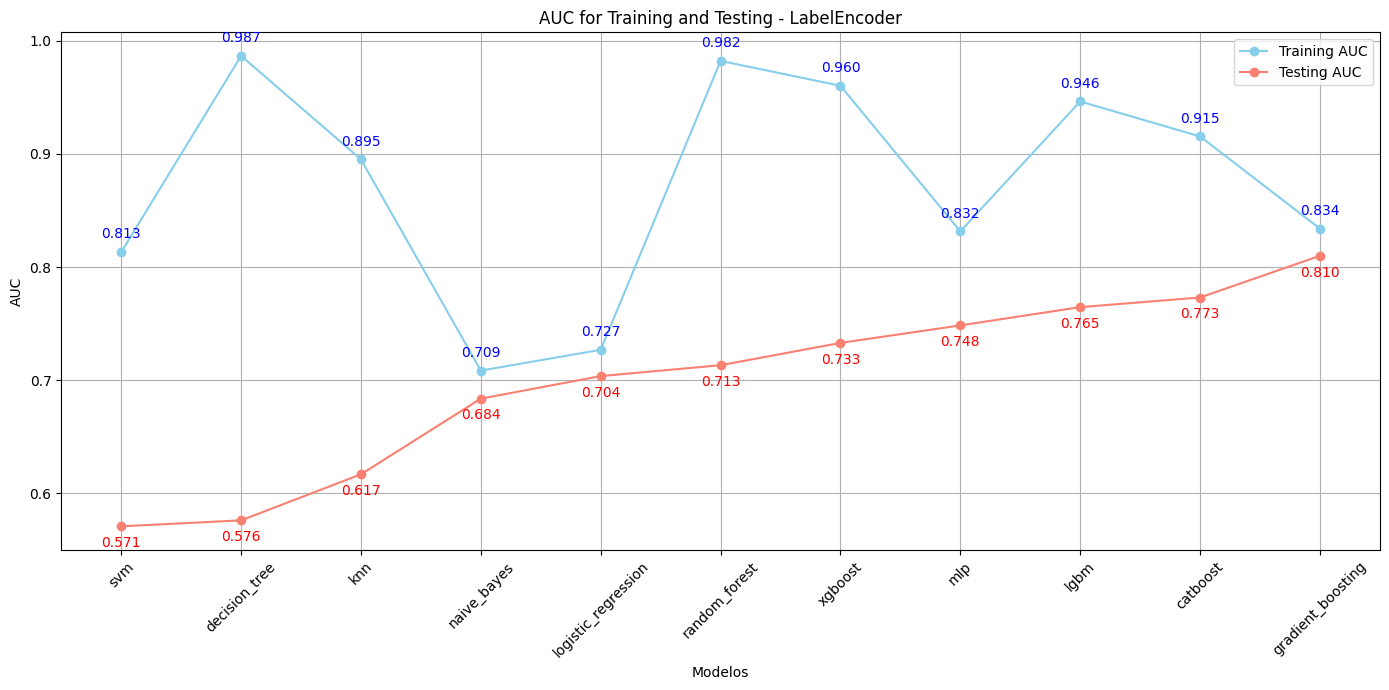

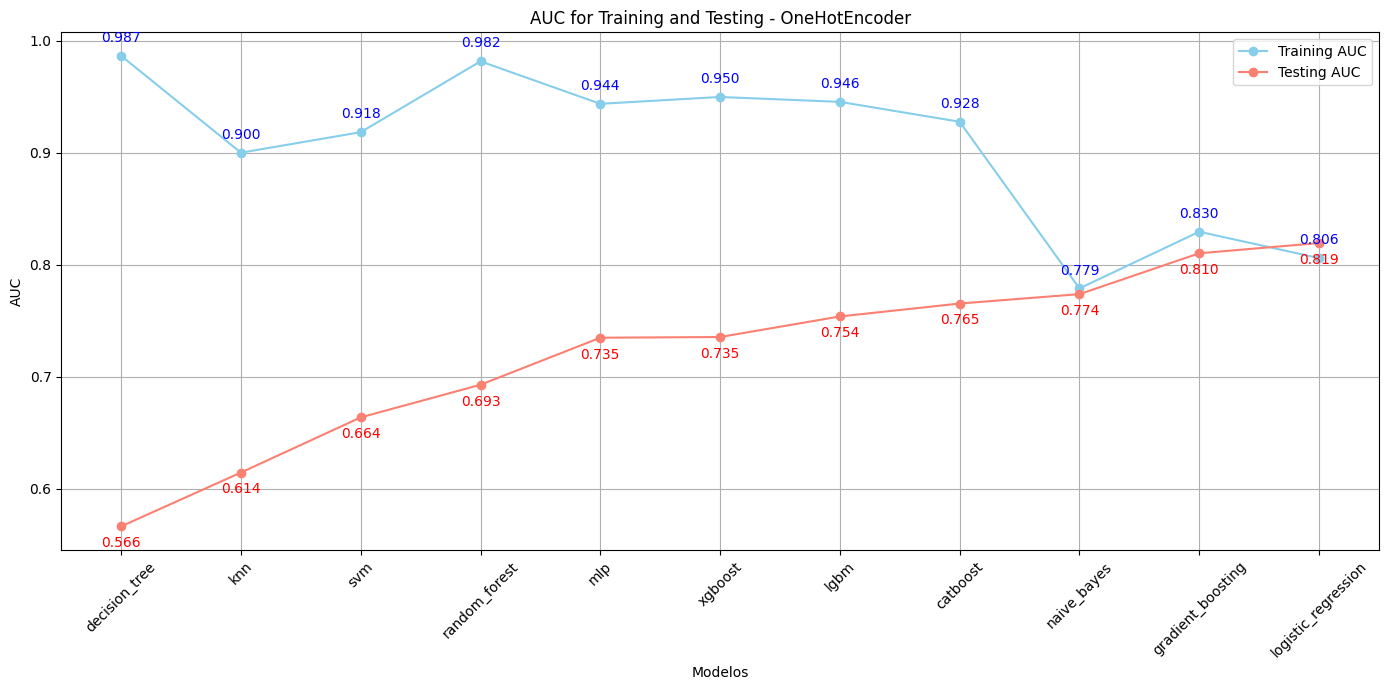

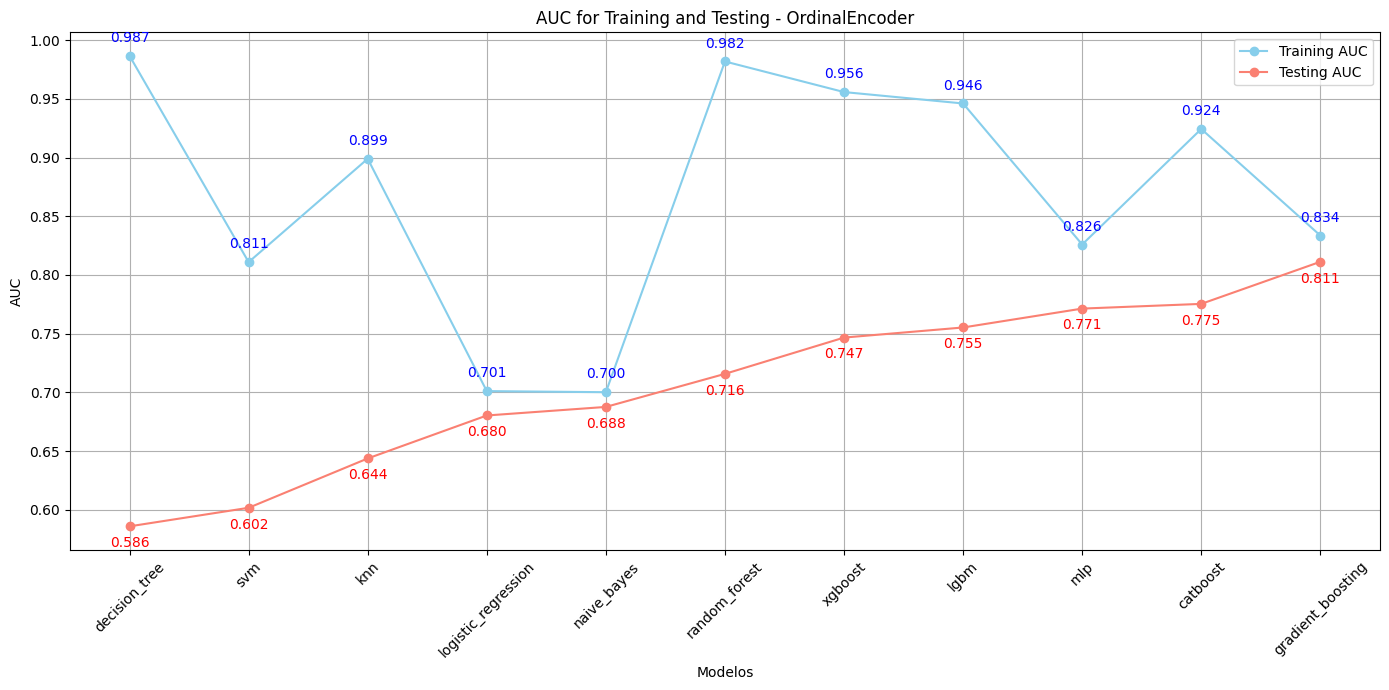

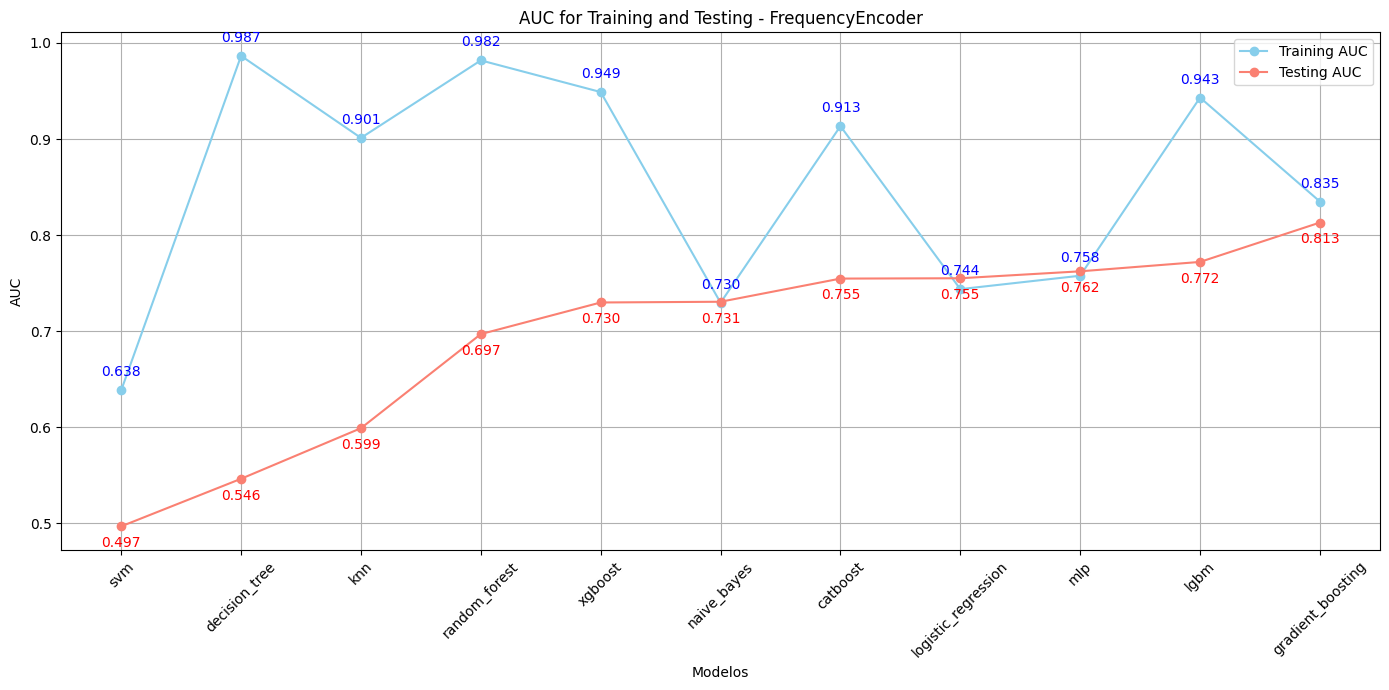

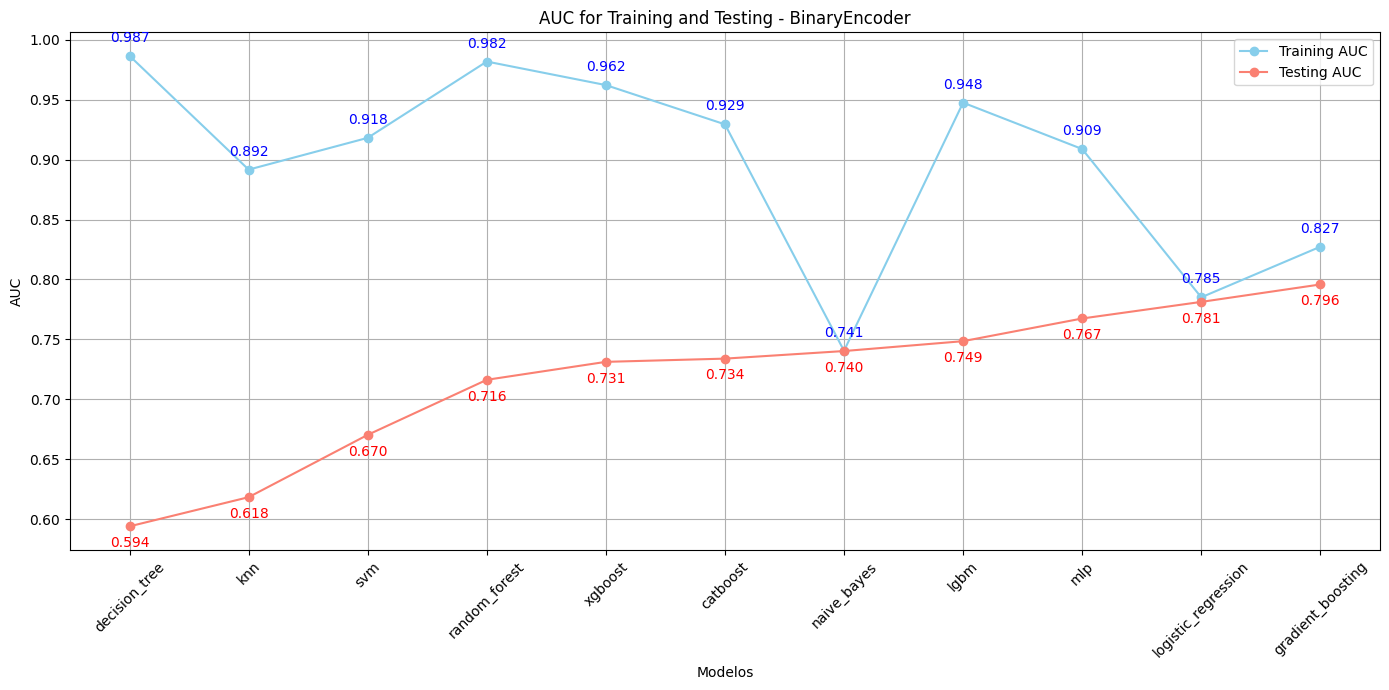

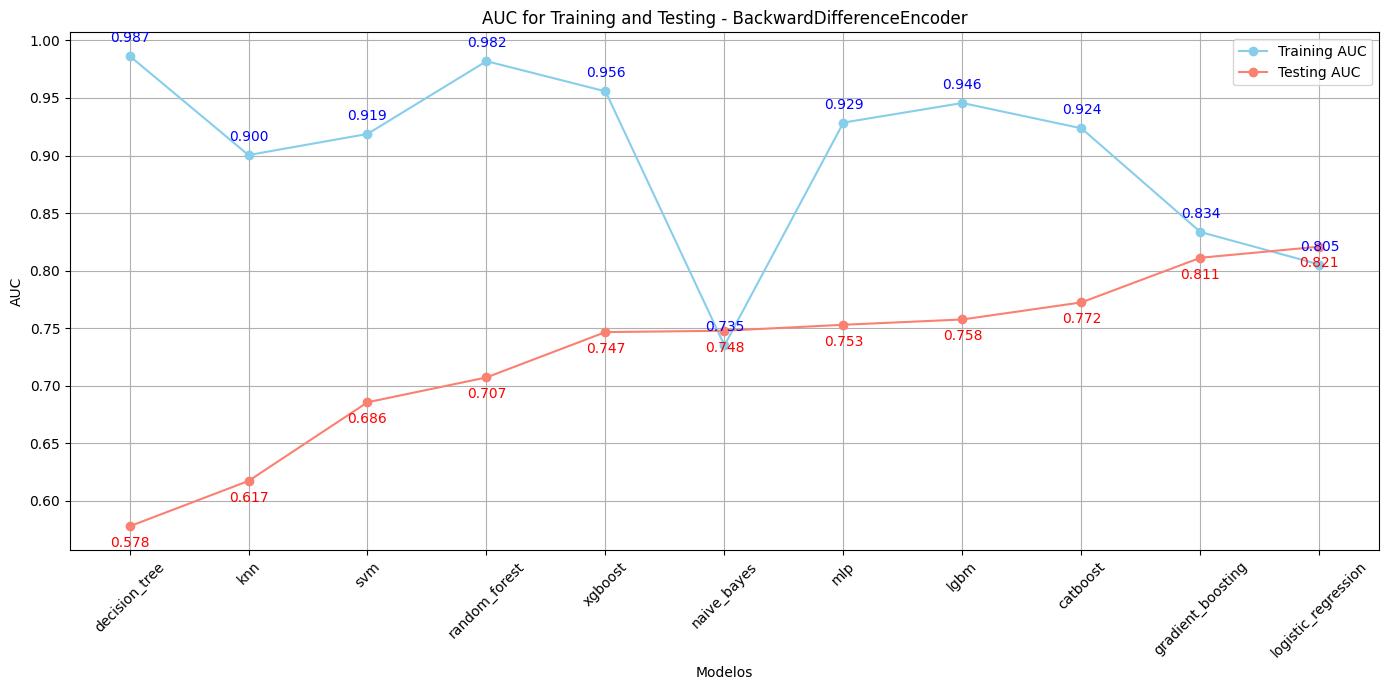

In [6]:
def plot_results(all_results):
    for encoded_method, sorted_names, train_aucs, test_aucs in all_results:
        # Ordenar los resultados por Testing AUC de menor a mayor
        sorted_indices = np.argsort(test_aucs)
        sorted_names = np.array(sorted_names)[sorted_indices]
        train_aucs = np.array(train_aucs)[sorted_indices]
        test_aucs = np.array(test_aucs)[sorted_indices]

        plt.figure(figsize=(14, 7))

        # Gráfico de líneas
        plt.plot(sorted_names, train_aucs, label='Training AUC', marker='o', color='skyblue')
        plt.plot(sorted_names, test_aucs, label='Testing AUC', marker='o', color='salmon')

        # Añadir los valores a los puntos
        for i, txt in enumerate(train_aucs):
            plt.annotate(f'{txt:.3f}', (sorted_names[i], train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        for i, txt in enumerate(test_aucs):
            plt.annotate(f'{txt:.3f}', (sorted_names[i], test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

        plt.xlabel('Modelos')
        plt.ylabel('AUC')
        plt.title(f'AUC for Training and Testing - {encoded_method}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Llamar a la función para generar los gráficos
plot_results(all_results)

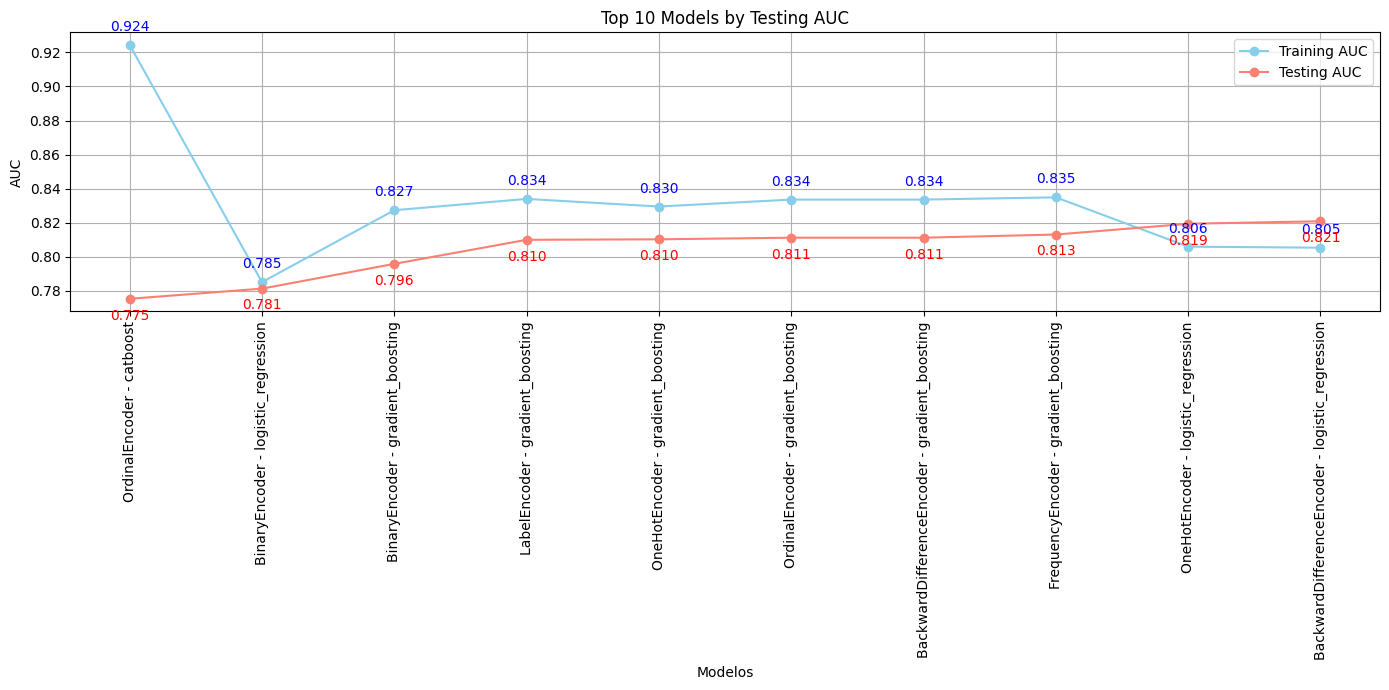

In [7]:
# Consolidar todos los resultados en una lista
consolidated_results = []
for encoded_method, sorted_names, train_aucs, test_aucs in all_results:
    for name, train_auc, test_auc in zip(sorted_names, train_aucs, test_aucs):
        full_model_name = f"{encoded_method} - {name}"
        consolidated_results.append((full_model_name, train_auc, test_auc))

# Ordenar los resultados por test_auc de mayor a menor y seleccionar el top 10
consolidated_results.sort(key=lambda x: x[2], reverse=False)
top_10_results = consolidated_results[-10:]

# Desempaquetar los resultados del top 10
top_10_names, top_10_train_aucs, top_10_test_aucs = zip(*top_10_results)

plt.figure(figsize=(14, 7))

# Gráfico de líneas para el top 10
plt.plot(top_10_names, top_10_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_10_names, top_10_test_aucs, label='Testing AUC', marker='o', color='salmon')

# Añadir los valores a los puntos
for i, txt in enumerate(top_10_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
for i, txt in enumerate(top_10_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_10_names[i], top_10_test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.title('Top 10 Models by Testing AUC')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
